# 19 - Evaluating Causal Models


인과관계에 관한 대부분의 자료에서 연구자들은 자신들의 방법을 확인하기 위해서 합성 데이터(synthetic data)를 사용합니다. 우리가 "예측이 실패했을 때(When Prediction Fails)"라는 장에서 한 것처럼, 연구자들은 $Y_0i$와 $Y_1i$에 대한 데이터를 생성하여 모델이 처치효과인 $Y_1i - Y_0i$를 올바르게 포착하는지 확인할 수 있었습니다. 이는 학문적인 목적으로는 괜찮지만, 현실에서는 이러한 사치를 누리기 어려울 수 있습니다. 이러한 기술을 현업에 적용할때 왜 우리 모델이 더 나은지, 왜 현재 활용하고 있는 모델을 대체해야 하는지 등의 질문을 몇 번이고 받을 수 있습니다. 특히, 인과관계 추론 모델에 대해 실제 데이터로 평가하는 방법을 설명하는 자료가 전혀 없다는 것은 이해할 수 없을 정도로 매우 중요한 문제입니다.

결과적으로 인과 추론 모델을 적용하려는 데이터 과학자는 경영진이 모델을 신뢰하도록 설득하는 데 매우 어려움을 겪습니다. 사내의 데이터 과학자로서 우리는 인과 관계 추론 모델의 바탕이되는 이론이 얼마나 탄탄한지, 그리고 모델을 학습할 때 얼마나 주의를 기울였는지를 보여줄 수 있습니다. 하지만 불행하게도, Hold-Out (훈련데이터와 테스트데이터를 분할하는 기법) 패러다임이 통용되는 세상에서 이런 방식으로는 충분하지 않습니다. 인과 추론 모델의 품질은 아름다운 이론보다 더 구체적인 기반 위에 근거해야 합니다. 한 번 생각해보죠. 머신러닝이 큰 성공을 거두기 시작한 것은 예측 모델 검증이 매우 간단했기 때문입니다. 예측이 실제로 발생한 것과 일치하는 것을 보는 것으로부터 우리는 머신러닝 모델의 일반화 성능을 확인할 수 있습니다.

그러나 인과 추론의 경우 Hold-Out 패러다임과 같은 검증 방법은 여전히 명확하지 않습니다. 그 이유는 인과 추론은 관측할 수 없는 양($\frac{\delta y}{ \delta t}$)을 추정하는 데 관심이 있기 때문입니다. 우리가 그것을 관측할 수 없다면, 어떻게 우리 모델이 그것을 잘 추정하는지 알 수 있을까요? 처치(treatment)와 결과 사이에 선의 기울기로 표현되는 모든 개체에는 내제된 반응(underlying responsiveness)이 있는 것 처럼 보이지만, 이를 측정할 수는 없습니다.

![sneak](./data/img/evaluate-causal-models/sneak.png)

이것은 매우 이해하기 어려운 문제이며, 근접한 해답을 찾는 데에는 수년이 걸렸습니다. 앞으로 제시할 방법은 100% 확실한 해답은 아니지만, 실제로 작동하며 구체성을 가지고 있기 때문에 기계 학습에서 활용한 Hold-Out 패러다임과 유사하게 인과 추론 모델의 평가에 근접할 수 있을 것입니다. 방법의 핵심은 민감성의 집계 측정(aggregate measurements of sensitivity)을 사용하는 것입니다. 개별적으로는 민감도(sensitivity)을 추정할 수 없어도, 그룹에 이러한 개념을 활용하여 민감도(sensitivity)을 추정할 수 있습니다.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from toolz import curry

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.ensemble import GradientBoostingRegressor

import warnings
warnings.filterwarnings("ignore")

이 장에서는 비무작위 데이터(non random)를 사용하여 인과 모델을 추정하고 무작위 데이터를 사용하여 이를 평가할 것입니다. 또한 전 장과 마찬가지로 가격이 아이스크림 판매에 어떤 영향을 미치는지에 대해 다시 한번 이야기할 것입니다. 보시다시피, 무작위 데이터는 평가 목적으로 매우 가치있는 데이터입니다. 그러나 실제 생활에서는 무작위 데이터를 수집하는 것은 종종 비용이 많이 듭니다(어떤 가격이 좋지 않고, 손해가 난다는 것을 알고 있는데 왜 무작위로 가격을 설정하겠습니까?). 결과적으로, 처치(Treatment)가 무작위가 아닌 데이터가 충분히 있고, 무작위 데이터는 거의 없거나 전혀 없는 경우가 많습니다. 비무작위 데이터로 모델을 평가하는 것이 굉장히 까다롭기 때문에, 무작위 데이터가 있으면 그것을 평가 목적으로 남겨두는 경향이 있습니다. 

혹시 잊어버리신 분들을 위하여, 데이터가 어떻게 생겼는지 한 번 파악해보죠.

In [2]:
prices = pd.read_csv("./data/ice_cream_sales.csv") # loads non-random data
prices_rnd = pd.read_csv("./data/ice_cream_sales_rnd.csv") # loads random data
print(prices_rnd.shape)
prices.head()

(5000, 5)


,temp,weekday,cost,price,sales
0,17.3,6,1.5,5.6,173
1,25.4,3,0.3,4.9,196
2,23.3,5,1.5,7.6,207
3,26.9,1,0.3,5.3,241
4,20.2,1,1.0,7.2,227


비교할 수 있도록 두 가지 모델을 학습해 보겠습니다. 첫 번째 모델은 상호작용 Term(interactions terms)이 있는 선형 회귀로, 단위 간에 민감성이 달라질 수 있도록 합니다.

$sales_i = \beta_0 + \beta_1 price_i + \pmb{\beta_2 X}_i + \pmb{\beta_3 X}_i price_i + e_i$

이 모델을 Fitting 시킨다면, 우리는 민감도(sensitivity)을 아래와 같이 예측할 수 있습니다.

$\widehat{\frac{\delta sales}{ \delta price}} = \hat{\beta_1} + \pmb{\hat{\beta_3} X}_i$

In [3]:
m1 = smf.ols("sales ~ price*cost + price*C(weekday) + price*temp", data=prices).fit()

두 번째 모델은 완전한 비모수적인 머신 러닝 예측 모델입니다.

$sales_i = G(X_i, price_i) + e_i$

In [23]:
X = ["temp", "weekday", "cost", "price"]
y = "sales"

np.random.seed(1)
m2 = GradientBoostingRegressor()
m2.fit(prices[X], prices[y])

GradientBoostingRegressor()

모델이 과적합되지 않았는지 확인하기 위해, 우리는 훈련에 사용된 데이터와 새로운 Unseen 데이터에서 모델을 성능을 확인할 수 있습니다 (여기서 머신러닝의 예측 성능 하락이 예상된다는 것을 알아두세요. 이는 분포의 드리프트 즉, 변화가 있기 때문입니다. 즉, 모델은 가격이 무작위가 아닌 데이터에서 훈련되었지만, 테스트 셋은 오직 무작위 가격만 포함하고 있음)

In [24]:
print("Train Score:", m2.score(prices[X], prices[y]))
print("Test Score:", m2.score(prices_rnd[X], prices_rnd[y]))

Train Score: 0.9251704824568053
Test Score: 0.7711074163447711


모델을 학습한 후 회귀 모델에서 탄력성을 얻습니다. 이때, 수치적 근사를 활용합니다. 

$\frac{\delta y(t)}{\delta t} \approx  \frac{y(t+h) - y(t)}{h}$

우리가 학습한 모델은 비무작위 데이터로 훈련했습니다. 이제 우리는 예측을 위해 무작위 데이터로 전환합니다. 한 곳에 모든 데이터를 합치기 위해, 기게 학습 모델에서 나온 예측과 인과 모델(선형 모델)에서 나온 민감성 예측을 단일 데이터프레임인 prices_rnd_pred로 합쳐볼게요.

추가적으로 무작위 모델(Random Model)을 포함시키겠습니다. 이 모델은 무작위 숫자를 예측값으로 출력합니다. 물론 이러한 모델이 유용하지는 않지만, 벤치마크로서 좋은 역할을 할 수 있을 겁니다. 우리는 새로운 평가 방법에 대해 이야기할 때, 항상 무작위 모델이 어떻게 할지 생각해 보곤 합니다. 무작위 모델이 평가 기준에서 좋은 성과를 낼 수 있다면, 이를 바탕으로 평가 방법이 실제로 얼마나 좋은지에 대해 말해줍니다.

In [8]:
def predict_sensitivity(model, price_df, h=0.01):
    return (model.predict(price_df.assign(price=price_df["price"]+h))
            - model.predict(price_df)) / h

np.random.seed(123)
prices_rnd_pred = prices_rnd.assign(**{
    "sensitivity_m_pred": predict_sensitivity(m1, prices_rnd), ## sensitivity model
    "pred_m_pred": m2.predict(prices_rnd[X]), ## predictive model
    "rand_m_pred": np.random.uniform(size=prices_rnd.shape[0]), ## random model
})

prices_rnd_pred.head()

,temp,weekday,cost,price,sales,sensitivity_m_pred,pred_m_pred,rand_m_pred
0,25.8,1,0.3,7,230,-13.096964,224.067406,0.696469
1,22.7,3,0.5,4,190,1.054695,189.889147,0.286139
2,33.7,7,1.0,5,237,-17.362642,237.255157,0.226851
3,23.0,4,0.5,5,193,0.564985,186.688619,0.551315
4,24.4,1,1.0,3,252,-13.717946,250.342203,0.719469


# Sensitivity by Model Band

이제 예측값이 준비되었으니, 얼마나 좋은지 평가해야 합니다. 그리고 위에서 말씀드린바와 같이 우리는 개별 민감성을 관찰할 수 없으므로, 비교할 수 있는 간단한 기준 값이 없습니다. 대신 민감도을 예측하는 모델에서 원하는 것이 무엇인지 다시 생각해봅시다. 그러면 모델을 어떻게 평가해야 할지에 대한 인사이트를 얻을 수 있을 것입니다.

처치 민감성 모델(treatment Sensitivity models)을 만들자는 아이디어는 어떤 유닛(개별 인스턴스)이 처치(Treatment)에 더 민간함지, 덜 민감한지를 찾아내는 필요성에서 왔습니다. 이는 우리가 잘아는 개인화에 대한 욕구에서 비롯된 것입니다. 아마도 마케팅팀에서 진행한 마케팅 캠페인이 특정한 인구 세그먼트에게만 효과가 있을 수 있습니다. 마찬가지로 할인은 일부 고객에게만 효과가 있을 수 있습니다. 좋은 인과 모델은 우리가 제안한 처치(Treatment)에 대해 더 잘 반응하거나 더 나쁘게 반응할 고객을 찾는 데 도움을 줄 수 있어야 합니다. 아이스크림의 예에서 모델은 어떤 요일에 사람들이 아이스크림에 더 많은 비용을 지출할 의향이 있는지, 또는 어떤 요일에 가격 민감성이 덜 음의 값을 갖는지 파악할 수 있어야 합니다.

이것이 목표라고 한다면, 어떻게든 더 민감한 유닛(개별 인스턴스 - Row)에서 덜 민감한 유닛으로 정렬할 수 있다면 매우 유용할 것입니다. 우리에게는 예측된 민감성이 있으므로 예측된 민감성에 따라 단위를 정렬할 수 있으며, 실제 민감성에도 따라 정렬되기를 바랍니다. 안타깝게도 개별 유닛 수준에서는 이러한 정렬의 순위를 평가할 수는 없습니다. 그런데, 우리가 개별에 대한 평가를 할 필요가 없다면 어떨까요? 대신 순서에 따라 정의된 그룹을 평가한다면 어떨까요? 우리의 처치(Treatment)가 무작위로 분배되었다면(여기서 무작위성이 들어갑니다), 단위 그룹에 대한 민감성을 추정하는 것은 쉽습니다. 처치(Treatment)받은 그룹과 Treatment를 받지 않는 그룹 간의 결과를 비교하기만 하면 됩니다.

이를 좀 더 쉽게 이해하기 위해, 이진 처치 사례(Binary Treatment Case)를 그림으로 묘사해보도록 할게요. 가격 예제를 계속 사용하지만, 이제 처치(Treatment)는 할인입니다. 즉, 가격은 높을 수도(untreated)있고, 가격이 낮을 수도(treated)있습니다. 매출을 Y축에, 각 모델을 X축에, 가격을 색상으로 플롯해 보겠습니다. 그런 다음 모델 축의 데이터를 동일한 크기의 세 그룹으로 나눌 수 있습니다. 처치(Treatment)가 무작위로 할당된 경우 각 그룹에 대한 ATE를 쉽게 추정할 수 있습니다. $E[Y|T=1] - E[Y|T=0]$

![ate_bins](./data/img/evaluate-causal-models/ate_bins.png)

이미지에서 첫 번째 모델은 매출 예측에 어느 정도 능숙하지만(매출과 높은 상관관계), 하단 플롯에서 볼 수 있듯이 이 모델이 생성하는 그룹은 거의 동일한 처치 효과(Treatment Effect)를 가지고 있음을 확인할 수 있습니다. 세 세그먼트 중 두 세그먼트는 동일한 민감도를 가지며 마지막 세그먼트만 낮은 민감도를 가집니다.

반면에 두 번째 모델에서 생성된 각 그룹은 서로 다른 민감도를 갖습니다. 이는 이 모델이 실제로 개인화에 유용할 수 있다는 신호입니다. 마지막으로 무작위 모델은 정확히 동일한 민감도를 가진 그룹을 생성합니다. 이는 그다지 유용하지는 않지만 예상되는 결과입니다. 모델이 무작위인 경우, 각 세그먼트는 무작위이고 대표적인 샘플이 될 것입니다. 그래서 그룹 내 민감도는 전체 데이터셋에 대한 ATE와 거의 동일해야 합니다. 

이 그래프를 본다면 어떤 모델이 더 나은지 알 수 있습니다. 민감도가 정돈되어 있고 밴드 간 차이가 클 수록 더 좋습니다. 여기서 모델2는 아마도 무작위 모델과 모델1보다 더 나은 것 같습니다.
이를 연속적인 경우로 일반화하기 위해 단변량 선형 회귀 모델을 사용하여 민감도를 추정할 수 있습니다. 

$y_i = \beta_0 + \beta_1t_i + e_i$

그룹의 샘플로 해당 모델을 실행하면 해당 그룹 내부의 민감도를 추정하게 됩니다.
단순 선형회귀 이론(단변량 회귀식에서 베타 추정)을 통해 다음과 같은 사실을 알 수 있습니다.

$\hat{\beta_1}=\dfrac{\sum (t_i - \bar{t}) (y_i - \bar{y})}{\sum(t_i - \bar{t})^2}$

여기서 $\bar{t}$는 Treatment의 표본 평균이고, $\bar{y}$는 결과의 표본 평균입니다. 이를 코드로 표현하면 다음과 같습니다.

In [9]:
@curry
def sensitivity(data, y, t):
        # line coeficient for the one variable linear regression 
        return (np.sum((data[t] - data[t].mean())*(data[y] - data[y].mean())) /
                np.sum((data[t] - data[t].mean())**2))

이제 이를 아이스크림 가격 데이터에 적용해 보겠습니다. 이를 위해서는 데이터 집합을 동일한 크기의 파티션으로 분할하고 각 파티션에 민감도를 적용하는 함수도 필요합니다. 다음 코드를 바탕으로 이를 처리하겠습니다.

In [10]:
def sensitivity_by_band(df, pred, y, t, bands=10):
    return (df
            .assign(**{f"{pred}_band":pd.qcut(df[pred], q=bands)}) # makes quantile partitions
            .groupby(f"{pred}_band")
            .apply(sensitivity(y=y, t=t))) # estimate the elasticity on each partition

마지막으로, 앞서 예측한 결과를 사용하여 밴드별 민감도를 플롯해 보겠습니다. 여기서는 각 모델을 사용하여 파티션을 구성한 다음 각 파티션의 민감도를 추정합니다.

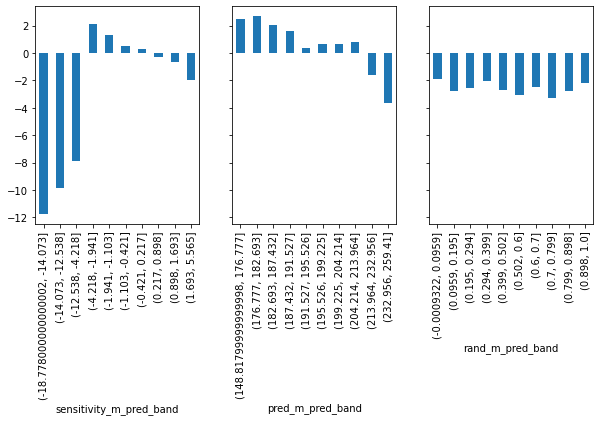

In [25]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 4))
for m, ax in zip(["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"], axs):
    sensitivity_by_band(prices_rnd_pred, m, "sales", "price").plot.bar(ax=ax)

먼저 랜덤 모델(rand_m)을 살펴봅시다. 이 모델은 각각의 파티션에서 거의 동일한 예상 민감도를 갖습니다. 즉, 해당 모델은 가격 민감도가 높은 날과 낮은 날을 구분할 수 없기 때문에 개인화에 큰 도움이 되지 않는다는 것을 플롯을 통해 확인할 수 있습니다. 다음으로, 예측 모델(pred_m)을 한 번 볼까요? 이 모델은 실제로 도움이 되는것 처럼 보입니다. 해당 모델은 민감도가 높은 그룹과 민감도가 낮은 그룹을 구성할 수 있으며, 이것이 바로 우리에게 필요한 것입니다.

마지막으로, 인과 관계 모델(sensitivity_m)은 약간 이상해 보입니다. 이 모델은 민감도가 매우 낮은 그룹을 식별하고 있는데, 여기서 낮은 것은 실제로 높은 가격 민감도(가격을 인상하면 매출이 많이 감소함)를 의미합니다. 가격 민감도가 높은 날은 파악하는 것은 우리에게 매우 유용한데, 언제 가격 민감도가 높은 날인지 알면 해당 날에 가격을 올리지 않도록 주의할 수 있기 때문입니다. 인과 모델은 또한 덜 민감한 지역을 식별하므로 높은 민감도와 낮은 민감도을 성공적으로 구분할 수 있어 보입니다. 그러나 순서는 예측 모델과 비교하여 그렇게 좋아보이지는 않습니다.

그래서 우리는 어떠한 결정을 내려야 할까요? 어떤 것이 더 유용한 모델일까요? 예측 또는 인과 모델? 예측 모델은 순서가 큰 구간부터 시작해 작은구간으로 구성되어 있지만, 인과 모델은 극단을 더 잘 식별할 수 있습니다. 밴드 플롯에 의한 민감도는 좋은 예시이지만 어떤 모델이 더 나은지 정확하게 답할 수 없습니다. 좀 더 정교한 방법으로 측정을 해봐야 합니다.

# Cumulative Sensitivity Curve

위에서 진행한 이진 처치 사례(Binary Treatment Case)의 예를 다시 고려해보겠습니다. 앞서 설명한 대로 밴드별로 Treatment의 민감도를 구했습니다. 다음으로 할 수 있는 일은 민감도에 따라 밴드의 순서를 정하는 것입니다. 즉, 가장 민감한 그룹을 첫 번째에, 두 번째로 민감한 그룹을 두 번째에 배치하는 식입니다. 모델 1과 모델 3의 경우 이미 순서대로 정렬이 되어 있으니, 다시 정렬할 필요는 없습니다. 모델 2의 경우 순서를 반대로 해야 합니다.

정렬된 그룹이 있으면 누적 민감도 곡선(Cumulative Sensitivity Curve)를 구성할 수 있습니다. 먼저 첫 번째 그룹의 민감도를 계산한 다음, 모든 그룹을 포함할 때까지 첫 번째 그룹과 두 번째 그룹의 민감도를 계산합니다. 이렇게 계산한다면 최종적으로는 전체 데이터 집합에 대한 민감도를 계산할 수 있습니다. 아래 예제의 모습을 한 번 볼까요?

![ate_bins](./data/img/evaluate-causal-models/cumm_elast.png)

누적 감도의 첫 번째 구간은 해당 모델에 따라 가장 민감한 그룹의 ATE입니다. 또한 모든 모델에 대해 누적 민감도는 전체 데이터세트의 ATE와 동일한 지점으로 수렴됩니다.

수학적으로 민누적 감도를 K 단위까지 추정된 민감도로 정의할 수 있습니다.

$\widehat{y'(t)}_k = \hat{\beta_1}_k=\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2}$

누적 민감도 곡선을 구하기 위해 데이터 세트에서 위의 함수를 반복적으로 실행하여 아래와 같은 시퀀스를 구성해줍니다.

$(\widehat{y'(t)}_1, \widehat{y'(t)}_2, \widehat{y'(t)}_3,..., \widehat{y'(t)}_N)$

이것은 모델 평가 측면에서 매우 흥미로운 시퀀스로, 모델에 대한 선호도 진술(preferences statements)을 할 수 있기 때문입니다.

첫째, 모델은 아래의 식의 정도만큼 더 나은 모델이라고 할 수 있습니다.

$\hat{y}'(t)_k > \hat{y}'(t)_{k+a}$ for any K and a>0

즉, 모델이 민감도 순서를 잘 정렬한다면, 상위 K개 샘플에서 관찰된 민감도가 상위 K+a개 샘플에서 관찰된 민감도보다 높아야 합니다. 간단하게 말해, 최상위 단위가 그 아래 단위보다 민감도가 높아야 한다는 뜻입니다.

둘째, 모델은 아래의 식이 가능한 커야 합니다. 즉, 상위 K 단위의 민감도가 하위 단위의 민감도보다 높아야 하며, 그 차의 크기가 가능한 큰 것이 좋은 모델이라고 할 수 있습니다.

$\hat{y}'(t)_k - \hat{y}'(t)_{k+a}$

조금 더 구체적으로 코드로 아이디어를 표현해보겠습니다.

In [26]:
def cumulative_sensitivity_curve(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    
    # orders the dataset by the `prediction` column
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    
    # create a sequence of row numbers that will define our Ks
    # The last item is the sequence is all the rows (the size of the dataset)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # cumulative computes the sensitivity. First for the top min_periods units.
    # then for the top (min_periods + step*1), then (min_periods + step*2) and so on
    return np.array([sensitivity(ordered_df.head(rows), y, t) for rows in n_rows])

이 함수에 대해 몇 가지 주의할 점이 있습니다. 이 함수는 민감도 순서를 지정한 항목이 prediction 열에 저장되어 있다고 가정합니다. 또한 첫 번째 그룹은 min_periods 단위가 있으므로 다른 그룹과 다를 수 있습니다. 그 이유는 샘플 크기가 작기 때문에 곡선의 시작 부분에서 민감도에 노이즈가 심할 수 있기 때문입니다. 이 문제를 해결하기 위해 이미 충분히 큰 첫 번째 그룹을 전달할 수 있습니다. 마지막으로, Steps은 각 후속 그룹에 포함할 추가 단위 수를 정의합니다.

이 함수를 사용하면 이제 각 모델에서 생성된 순서에 따라 아래와 같이 누적 감도 곡선을 그릴 수 있습니다.

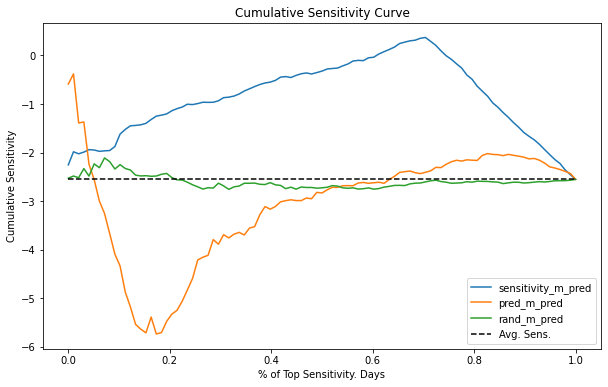

In [14]:
plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_sens = cumulative_sensitivity_curve(prices_rnd_pred, m, "sales", "price", min_periods=100, steps=100)
    x = np.array(range(len(cumu_sens)))
    plt.plot(x/x.max(), cumu_sens, label=m)

plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Sens.")
plt.xlabel("% of Top Sensitivity. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity Curve")
plt.legend()

누적 민감도 곡선을 해석하는 것은 다소 어려울 수 있지만, 제가 생각하는 방식은 다음과 같습니다. 곡선의 X축은 얼마나 많은 샘플을 처리하고 있는지를 나타냅니다. 여기서는 축을 데이터 집합의 비율로 정규화했으므로 0.4는 샘플의 40%를 처리하고 있음을 의미합니다. Y축은 해당 수의 샘플에서 기대할 수 있는 감도입니다. 따라서 곡선의 값이 40%에서 -1이면 상위 40% 단위의 감도가 -1이라는 뜻입니다. 

이상적으로는 가능한 가장 큰 샘플에 대해 가장 높은 민감도를 원합니다. 이상적인 곡선은 Y축의 높은 위치에서 시작하여 평균 감도까지 매우 천천히 내려가는데, 이는 평균 이상의 감도를 유지하면서 높은 비율의 유닛을 처리할 수 있음을 나타냅니다.

당연히 어떤 모델도 이상적인 감도 곡선에 근접하지 못했습니다.랜덤 모델(rand_m)은 평균 감도를 중심으로 진동하며 평균 감도에서 너무 멀리 벗어나지 않습니다. 이는 감도가 평균 감도와 다른 그룹을 찾을 수 없다는 것을 의미합니다. 

예측 모델 pred_m의 경우, 곡선이 평균 민감도 아래에서 시작하기 때문에 민감도가 역순으로 정렬되는 것처럼 보입니다. 뿐만 아니라 샘플의 약 50%에서 평균 감도에 매우 빠르게 수렴합니다. 마지막으로 인과 관계 모델의 민감도는 조금 흥미롭습니다. 처음에는 누적 민감도가 평균에서 멀어지는 이상한 동작을 보이다가, 거의 0에 가까운 꽤 괜찮은 민감도를 유지하면서 단위의 약 75%를 처리할 수 있는 지점에 도달합니다. 이는 아마도 이 모델이 매우 낮은 민감도(높은 가격 민감도)의 날을 식별할 수 있기 때문에 발생하는 현상일 것입니다. 따라서 낮은 민감도에 해당하는 날짜에 가격을 인상하지 않았지만, 대부분의 샘플(약 75%)에 대해 민감도가 낮기 때문에 가격을 인상할 수 있습니다.

모델 평가 측면에서 누적 민감도 곡선은 이미 밴드별 민감도라는 단순한 개념보다 훨씬 더 나은 모델입니다. 이를 통해 훨씬 더 정확한 모델에 대한 선호도 평가를 할 수 있습니다. 하지만 여전히 이해하기에는 복잡한 곡선입니다. 따라서 한 가지 더 개선할 수 있습니다.

# Cumulative Gain Curve

다음 아이디어는 누적 감도를 매우 간단하면서도 강력하게 개선하는 방식입니다. 바로 누적 민감도에 비례하는 샘플 크기를 곱하는 것입니다. 예를 들어 누적 감도가 40%에서 -0.5라면, 이 시점에서 -0.2 =(-0.5 * 0.4)가 됩니다. 그런 다음 이를 무작위 모델을 바탕으로 생성한 곡선과 비교합니다. 이 곡선은 실제로 0에서 ATE까지 직선으로 표현될 것입니다. 무작위 모델은 데이터의 무작위 대표 분할( random representative partitions of the data)을 생성하기 때문에 무작위 모델의 누적 민감도의 모든 지점이 ATE입니다. (0,1) 선을 따라 각 지점에서 ATE에 해당 지점을 곱하면 0과 ATE 사이에 직선이 생깁니다.

![ate_bins](./data/img/evaluate-causal-models/cumm_gain.png)

이론적인 임의 곡선이 있으면 이를 벤치마크로 사용하고 다른 모델과 비교할 수 있습니다. 모든 커브는 같은 지점에서 시작하고 끝납니다. 그러나 민감도에서 모델이 좋을수록 곡선이 0과 1 사이의 점에서 임의의 선에서 더 많이 멀어집니다. 예를 들어 위의 이미지에서 M2는 끝점에서 ATE에 도달하기 전에 더 많이 멀어져 있기 때문에 M1보다 낫습니다. ROC 곡선에 익숙한 사용자는 이러한 누적 이득곡선(Cumulative Gain Curve)을 인과 모델의 ROC Curve로 생각할 수 있습니다.

수하적으로 말하면 아래와 같이 표현할 수 있습니다.

$\widehat{F(t)}_k = \hat{\beta_1}_k * \frac{k}{N} =\dfrac{\sum_i^k (t_i - \bar{t}) (y_i - \bar{y})}{\sum_i^k(t_i - \bar{t})^2} * \frac{k}{N}$

코드에서 이를 구현하려면 샘플 크기 비례 정규화를 추가하기만 하면 됩니다.

In [15]:
def cumulative_gain(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    ## add (rows/size) as a normalizer. 
    return np.array([sensitivity(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

아이스크림 데이터의 경우 아래와 같은 곡선을 얻을 수 있습니다.

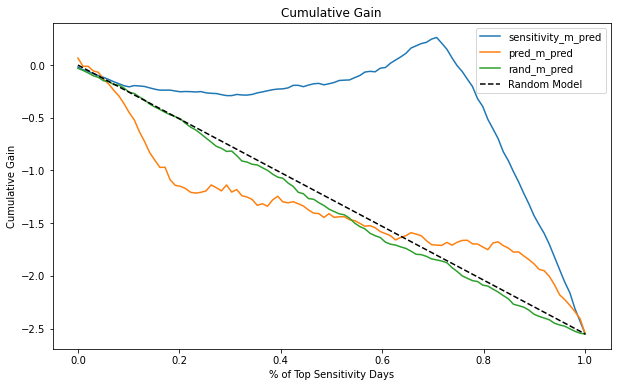

In [16]:
plt.figure(figsize=(10,6))

for m in ["sensitivity_m_pred", "pred_m_pred", "rand_m_pred"]:
    cumu_gain = cumulative_gain(prices_rnd_pred, m, "sales", "price", min_periods=50, steps=100)
    x = np.array(range(len(cumu_gain)))
    plt.plot(x/x.max(), cumu_gain, label=m)
    
plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain")
plt.legend()

이제 인과 모델(sensitivity_m)이 다른 두 모델보다 훨씬 낫다는 것이 매우 분명해졌습니다. 이 모델은 rand_m과 pred_m보다 무작위 선에서 훨씬 더 많이 벗어납니다. 또한 실제 랜덤 모델이 이론적 랜덤 모델을 매우 밀접하게 따르는 것에 주목해보세요. 둘 사이의 차이가 발생하는 것은 아마도 무작위 노이즈 때문 일 것입니다.

지금까지 인과 관계 모델을 평가하는 방법에 대한 몇 가지 좋은 아이디어를 살펴보았습니다. 그것만으로도 큰 성과입니다. 비교할 근거 자료가 없음에도 불구하고 민감도 순서에 따라 모델이 얼마나 좋은지 평가할 수 있었습니다. 마지막으로 한 가지 빠진 것이 있는데, 바로 측정값에 대한 신뢰 구간을 포함시키는 것입니다. 우리는 야만인이 아니니깐요!

![ate_bins](./data/img/evaluate-causal-models/uncivilised.png)

# Taking Variance Into Account
민감도 곡선을 다룰 때 분산을 고려하지 않는 것은 잘못된 것 처럼 느껴집니다. 특히 모두 선형 회귀 이론을 사용하기 때문에 신뢰 구간을 추가하는 것은 매우 쉬울 것입니다.

이를 위해 먼저 선형 회귀 매개 변수에 대한 CI를 반환하는 함수를 만들겠습니다. 여기서는 간단한 선형 회귀에 대한 공식을 사용했지만, 원하는 대로 자유롭게 CI를 추출할 수 있습니다.

$s_{\hat\beta_1}=\sqrt{\frac{\sum_i\hat\epsilon_i^2}{(n-2)\sum_i(t_i-\bar t)^2}}$

In [17]:
def sensitivity_ci(df, y, t, z=1.96):
    n = df.shape[0]
    t_bar = df[t].mean()
    beta1 = sensitivity(df, y, t)
    beta0 = df[y].mean() - beta1 * t_bar
    e = df[y] - (beta0 + beta1*df[t])
    se = np.sqrt(((1/(n-2))*np.sum(e**2))/np.sum((df[t]-t_bar)**2))
    return np.array([beta1 - z*se, beta1 + z*se])

cumulative_sensitivity_curve 함수를 약간 수정하면 감도에 대한 신뢰 구간을 출력할 수 있습니다.

In [19]:
def cumulative_sensitivity_curve_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    
    # just replacing a call to `sensitivity` by a call to `sensitivity_ci`
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t)  for rows in n_rows])

마지막으로 인과 관계 모델에 대한 95% CI가 포함된 누적 민감도 곡선은 다음과 같습니다.

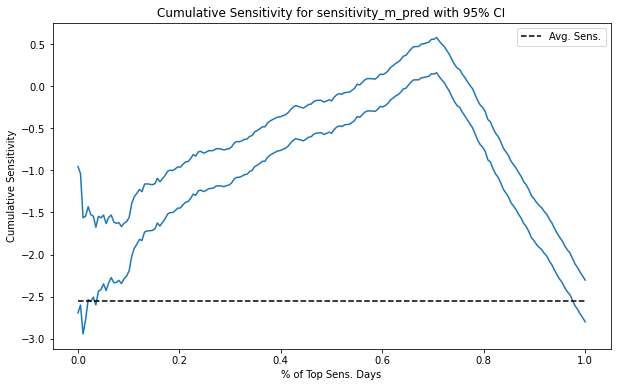

In [20]:
plt.figure(figsize=(10,6))

cumu_gain_ci = cumulative_sensitivity_curve_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain_ci)))
plt.plot(x/x.max(), cumu_gain_ci, color="C0")

plt.hlines(sensitivity(prices_rnd_pred, "sales", "price"), 0, 1, linestyles="--", color="black", label="Avg. Sens.")

plt.xlabel("% of Top Sens. Days")
plt.ylabel("Cumulative Sensitivity")
plt.title("Cumulative Sensitivity for sensitivity_m_pred with 95% CI")
plt.legend()

데이터가 더 많이 축적할수록 CI가 점점 더 작아지는 것을 볼 수 있습니다. 이는 샘플 크기가 증가하기 때문입니다.

누적 이득 곡선의 경우에도 마찬가지로 간단하게 CI를 구할 수 있습니다. 다시 말하지만, sensitivity 함수를 아래와 같이 sensitivity_ci 함수로 대체하기만 하면 됩니다.

In [21]:
def cumulative_gain_ci(dataset, prediction, y, t, min_periods=30, steps=100):
    size = dataset.shape[0]
    ordered_df = dataset.sort_values(prediction, ascending=False).reset_index(drop=True)
    n_rows = list(range(min_periods, size, size // steps)) + [size]
    return np.array([sensitivity_ci(ordered_df.head(rows), y, t) * (rows/size) for rows in n_rows])

이제 곡선의 시작 부분에서 표본 크기가 더 작음에도 불구하고 CI가 작게 시작하는 것을 알 수 있습니다. 그 이유는 정규화 계수(k/n)가 가 ATE 매개 변수를 축소하고 CI도 함께 축소하기 때문입니다. 이 곡선은 모델을 비교하는 데 사용되어야 하므로 이 축소된 계수가 평가되는 모든 모델에 동일하게 적용되기 때문에 문제가 되지 않습니다.

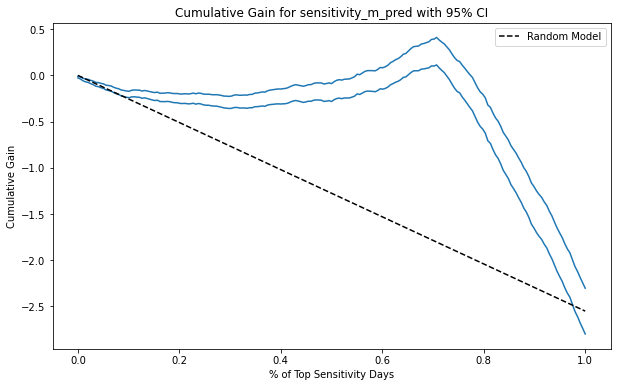

In [22]:
plt.figure(figsize=(10,6))

cumu_gain = cumulative_gain_ci(prices_rnd_pred, "sensitivity_m_pred", "sales", "price", min_periods=50, steps=200)
x = np.array(range(len(cumu_gain)))
plt.plot(x/x.max(), cumu_gain, color="C0")

plt.plot([0, 1], [0, sensitivity(prices_rnd_pred, "sales", "price")], linestyle="--", label="Random Model", color="black")

plt.xlabel("% of Top Sensitivity Days")
plt.ylabel("Cumulative Gain")
plt.title("Cumulative Gain for sensitivity_m_pred with 95% CI")
plt.legend();

# Key Ideas
여기서 우리는 민감도를 정렬한 모델이 얼마나 효과적인가를 파악하는 세 가지 방법에 대해서 알아봤습니다. 인과 목적이 있는 모델을 비교하고 결정하는 방법으로 위의 3가지 방법을 활용해보았습니다. 이것은 인과 모델의 활용성 측면에서 매우 중요한 문제입니다. 개별 인스턴스의 민감도를 볼 수 없어도 모델의 민감도가 다른 그룹을 식별하는 데 효과적인지 확인할 수 있었습니다. 

여기서 우리는 Random 데이터에 크게 의존했습니다. 무작위가 아닌 데이터로 모델을 훈련했지만, 민감도를 확실하게 추정할 수 있는 방법이 필요했기 때문에 모든 평가는 Treatment가 무작위로 이루어진 샘플에서 이루어졌습니다. 무작위 데이터가 없으면 여기서 사용한 간단한 공식은 작동하지 않습니다. 지금까지 잘 알고 있듯이, 단순 선형 회귀는 교란 변수가 있을 때 변수 편향이 생략됩니다. 

그럼에도 불구하고 임의의 데이터를 확보할 수 있다면 임의의 모델을 비교하는 방법을 이미 알고 있습니다. 다음 장에서는 무작위가 아닌 데이터의 문제를 다룰 것이지만, 그 전에 모델 평가에 대해 마지막으로 말씀드리고 싶었습니다.

추가적으로 신뢰할 수 있는 모델 평가가 얼마나 중요한지 다시 한 번 강조하였습니다. 우리는 본 챕터에서 누적 이득 곡선을 통해 인과 관계 추론에 사용되는 모델을 비교할 수 있는 좋은 방법에 대한 아이디어를 얻었습니다. 이제 어떤 모델이 Treatment의 개인화에 더 적합한지 결정할 수 있습니다.인과 관계 추론에서 찾을 수 있는 대부분의 자료는 모델 평가를 위한 좋은 방법을 제공하지 않습니다. 
제 생각에는 인과 추론이 머신 러닝만큼 대중화되기 위해 필요한 부분이 바로 이 부분입니다. 좋은 평가 방식을 통해 인과 추론을 예측 모델링에 매우 유용했던 훈련-테스트 패러다임(Hold-out)에 더 가깝게 만들 수 있습니다. 조심스럽게 말하지만, 아직까지 이러한 평가 방식에 대한 좋은 비판과 토론의 장이 마련되지 않은것 같습니다. 좋은 의견이 있으면 알려주세요.

# References

제가 여기에 쓴 글은 대부분 제 머릿속에서 나온 내용입니다. 저는 해당 내용을 경험을 통해 배웠습니다. 즉, 과학이 거치는 학문적 조사를 통과하지 못했다는 뜻입니다. 대신 실제로 작동하는 것에 대해 이야기하고 있지만 왜 그런지 설명하는 데 너무 많은 시간을 할애하지 않았습니다. 일종의 길거리 과학(science from the streets)이라고 할 수 있습니다. 그러나 저는 이 내용을 공개적으로 검토하기 위해 이 글을 올리는 것이니, 터무니없는 내용이 있으면 문제를 제기해 주시면 최선을 다해 해결해 드리겠습니다.

이 장의 아이디어는 Pierre Gutierrez와 Jean-Yves G'erardy의 논문 '인과적 추론과 상향식 모델링: 문헌 검토'에서 얻었습니다. 저자들은 Qini 곡선의 개념을 설명합니다. 검색해보면 Treatment가 이원적일 때 인과적 추론이라고 생각할 수 있는 Uplift 모델링에 사용되는 기법이라는 것을 알 수 있습니다. 여기서는 Quni 곡선에서 아이디어를 가져와 continuous treatment 사례에 일반화했습니다. 여기에 제시된 방법은 연속형과 이원형 모두에 적용될 수 있다고 생각하지만, 다른 곳에서는 본 적이 없으므로 이 점을 염두에 두시기 바랍니다.

또한 훈련-테스트 패러다임에 관한 Leo Breiman(2001)의 글 'Statistical Modeling: The Two Cultures'을 읽어보실 것을 강력히 추천합니다. 통계적 기법의 성공 요인을 이해하고자 한다면 훌륭한 자료입니다.

# Contribute
Causal Inference for the Brave and True는 인과추론, 통계학에 대한 오픈소스 자료입니다. 이 자료는 금전적으로나 모든 분들이 쉽게 접근하실 수 있도록 하는 것이 목표입니다. 또한, 이 책은 Python 기반의 무료 소프트웨어만 사용해요. 여러분들께서 이 자료가 가치 있다고 생각하시고, 금전적으로 지원을 원하신다면 Patreon를 방문해주세요. 만약 여러분이 금전적으로 기여하기가 쉽지 않으시다면, 오타 수정, 수정 제안, 이해하기 난해한 부분에 대한 피드백 제공 등을 통해 도움을 주실 수 있어요. 이 책의 Github 저장소 이슈 페이지를 방문해주세요. 마지막으로 이 자료가 여러분의 마음에 드셨다면 도움이 될 수 있는 다른 사람들과 공유해주시고, 한국어 번역 자료와 해당 번역본의 원서에 star 부탁드립니다!